# Anime Recommendation System - Complete Walkthrough

Notebook này cung cấp một walkthrough hoàn chỉnh của hệ thống gợi ý phim anime, bao gồm:

1. **Exploratory Data Analysis (EDA)** - Phân tích và khám phá dữ liệu
2. **Model Training** - Huấn luyện các mô hình recommendation
3. **Model Evaluation** - Đánh giá và so sánh hiệu suất
4. **Demo** - Thử nghiệm hệ thống gợi ý

---

## 1. Setup & Import Libraries

Cài đặt và import các thư viện cần thiết.

In [18]:
# Import standard libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add backend to path
sys.path.append(os.path.abspath('backend'))

# Data manipulation
import pandas as pd
import numpy as np
from collections import defaultdict

# Database
from pymongo import MongoClient
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Models
from ml.models.user_based import UserBasedCF
from ml.models.item_based import ItemBasedCF
from ml.models.hybrid import HybridWeightedCF as HybridCF
from ml.training.evaluate import evaluate_model, compare_models

# Configure plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Connect to Database

Kết nối đến MongoDB và load dữ liệu.

In [19]:
# Load environment variables
load_dotenv('backend/.env')

# MongoDB connection
MONGODB_URI = os.getenv('MONGODB_URI', 'mongodb://localhost:27017/')
MONGODB_DB = os.getenv('MONGODB_DB', 'anime_recommendation')

print(f"Connecting to MongoDB: {MONGODB_URI}")
client = MongoClient(MONGODB_URI)
db = client[MONGODB_DB]

# Test connection
print(f"Connected! Database: {MONGODB_DB}")
print(f"Collections: {db.list_collection_names()}")

Connecting to MongoDB: mongodb://localhost:27017/
Connected! Database: anime_recommendation
Collections: ['model_registry', 'ratings', 'watch_history', 'users', 'animes']


## 3. EDA - Load và Explore Dữ liệu

### 3.1 Load Data từ MongoDB

In [20]:
# Load anime data
print("Loading anime data...")
animes = list(db.animes.find())
df_animes = pd.DataFrame(animes)

# Load ratings data (sample for speed)
print("Loading ratings data...")
ratings = list(db.ratings.find().limit(100000))  # Sample 100k ratings
df_ratings = pd.DataFrame(ratings)

print(f"\nData loaded successfully!")
print(f"   - Animes: {len(df_animes):,}")
print(f"   - Ratings: {len(df_ratings):,}")
print(f"   - Users: {df_ratings['user_id'].nunique():,}")

Loading anime data...
Loading ratings data...

Data loaded successfully!
   - Animes: 16,214
   - Ratings: 100,000
   - Users: 575


### 3.2 Dataset Overview

In [21]:
print("=" * 60)
print("ANIME DATASET")
print("=" * 60)
print(f"\nShape: {df_animes.shape}")
print(f"\nColumns: {df_animes.columns.tolist()}")
print(f"\nFirst few rows:")
df_animes.head()

ANIME DATASET

Shape: (16214, 6)

Columns: ['_id', 'mal_id', 'name', 'score', 'genres', 'synopsis']

First few rows:


,_id,mal_id,name,score,genres,synopsis
0,69329cd7fc1d716debac1950,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,69329cd7fc1d716debac1951,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,69329cd7fc1d716debac1952,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,69329cd7fc1d716debac1953,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,69329cd7fc1d716debac1954,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [22]:
print("=" * 60)
print("RATINGS DATASET")
print("=" * 60)
print(f"\nShape: {df_ratings.shape}")
print(f"\nColumns: {df_ratings.columns.tolist()}")
print(f"\nFirst few rows:")
df_ratings.head()

RATINGS DATASET

Shape: (100000, 4)

Columns: ['_id', 'user_id', 'anime_id', 'rating']

First few rows:


,_id,user_id,anime_id,rating
0,69329cd9fc1d716debac58a6,0,430,9
1,69329cd9fc1d716debac58a7,0,1004,5
2,69329cd9fc1d716debac58a8,0,3010,7
3,69329cd9fc1d716debac58a9,0,570,7
4,69329cd9fc1d716debac58aa,0,2762,9


In [23]:
# Statistical summary
print("\nANIME STATISTICS")
print("=" * 60)
print(df_animes[['score']].describe())

print("\nRATING STATISTICS")
print("=" * 60)
print(df_ratings[['rating']].describe())


ANIME STATISTICS
              score
count  16214.000000
mean       4.483778
std        3.137095
min        0.000000
25%        0.000000
50%        6.035000
75%        6.900000
max        9.190000

RATING STATISTICS
              rating
count  100000.000000
mean        7.592990
std         1.706383
min         1.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        10.000000


### 3.3 Data Quality Check

In [24]:
# Missing values
print("MISSING VALUES ANALYSIS")
print("=" * 60)
print("\nAnime dataset:")
print(df_animes.isnull().sum())

print("\nRatings dataset:")
print(df_ratings.isnull().sum())

# Duplicates
print("\n\nDUPLICATES ANALYSIS")
print("=" * 60)
print(f"Duplicate animes: {df_animes.duplicated(subset=['mal_id']).sum()}")
print(f"Duplicate ratings: {df_ratings.duplicated(subset=['user_id', 'anime_id']).sum()}")

MISSING VALUES ANALYSIS

Anime dataset:
_id         0
mal_id      0
name        0
score       0
genres      0
synopsis    0
dtype: int64

Ratings dataset:
_id         0
user_id     0
anime_id    0
rating      0
dtype: int64


DUPLICATES ANALYSIS
Duplicate animes: 0
Duplicate ratings: 0


## 4. EDA - Visualizations

### 4.1 Rating Distribution

In [25]:
# Rating distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('User Ratings Distribution', 'Anime Score Distribution')
)

# User ratings
rating_counts = df_ratings['rating'].value_counts().sort_index()
fig.add_trace(
    go.Bar(x=rating_counts.index, y=rating_counts.values, name='User Ratings',
           marker_color='skyblue'),
    row=1, col=1
)

# Anime scores
fig.add_trace(
    go.Histogram(x=df_animes['score'], name='Anime Scores',
                 marker_color='coral', nbinsx=20),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False, title_text="Rating Distributions")
fig.update_xaxes(title_text="Rating", row=1, col=1)
fig.update_xaxes(title_text="Score", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)
fig.show()

### 4.2 Genre Analysis

In [26]:
# Extract genres
all_genres = []
for genres in df_animes['genres'].dropna():
    if isinstance(genres, str):
        all_genres.extend([g.strip() for g in genres.split(',') if g.strip()])

genre_counts = pd.Series(all_genres).value_counts().head(15)

# Plot top genres
fig = px.bar(
    x=genre_counts.values,
    y=genre_counts.index,
    orientation='h',
    title='Top 15 Anime Genres',
    labels={'x': 'Count', 'y': 'Genre'},
    color=genre_counts.values,
    color_continuous_scale='Viridis'
)
fig.update_layout(height=500, showlegend=False)
fig.show()

### 4.3 Top Rated Animes

In [27]:
# Calculate average ratings per anime
anime_ratings = df_ratings.groupby('anime_id').agg({
    'rating': ['mean', 'count']
}).reset_index()
anime_ratings.columns = ['anime_id', 'avg_rating', 'rating_count']

# Filter animes with at least 50 ratings
popular_animes = anime_ratings[anime_ratings['rating_count'] >= 50]

# Get top 10 by average rating
top_10 = popular_animes.nlargest(10, 'avg_rating')

# Merge with anime names
top_10 = top_10.merge(df_animes[['mal_id', 'name']], left_on='anime_id', right_on='mal_id')

# Plot
fig = px.bar(
    top_10,
    x='avg_rating',
    y='name',
    orientation='h',
    title='Top 10 Highest Rated Animes (min 50 ratings)',
    labels={'avg_rating': 'Average Rating', 'name': 'Anime'},
    text='avg_rating',
    color='avg_rating',
    color_continuous_scale='Plasma'
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(height=500, showlegend=False)
fig.show()

### 4.4 User Engagement Analysis

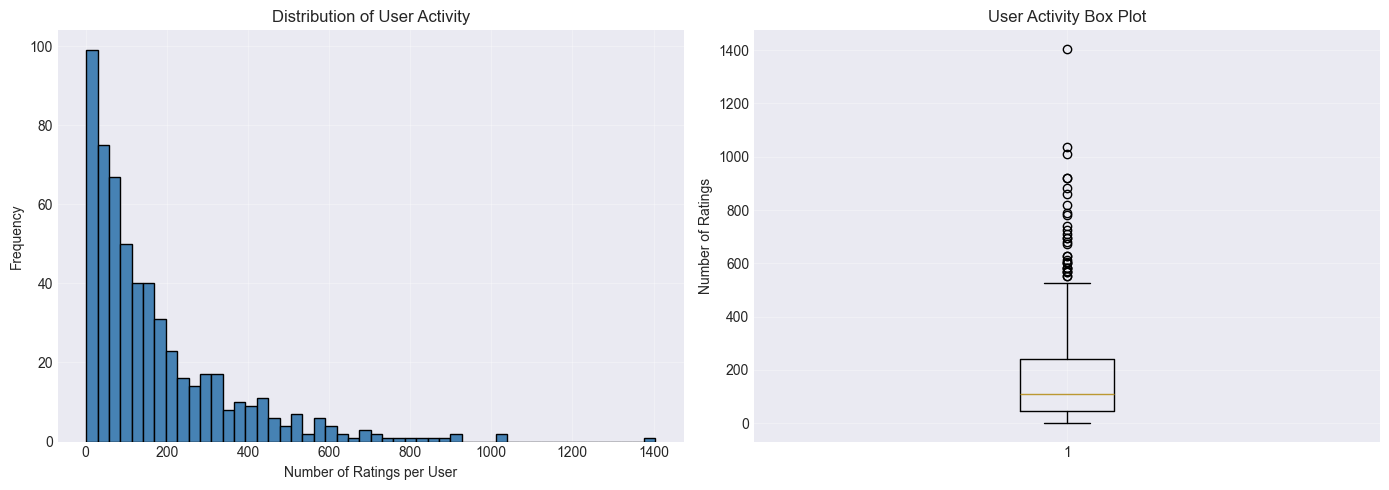


User Engagement Statistics:
   - Mean ratings per user: 173.91
   - Median ratings per user: 108.00
   - Max ratings by a user: 1404


In [28]:
# Ratings per user
ratings_per_user = df_ratings.groupby('user_id').size()

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(ratings_per_user, bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Ratings per User')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of User Activity')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(ratings_per_user, vert=True)
axes[1].set_ylabel('Number of Ratings')
axes[1].set_title('User Activity Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUser Engagement Statistics:")
print(f"   - Mean ratings per user: {ratings_per_user.mean():.2f}")
print(f"   - Median ratings per user: {ratings_per_user.median():.2f}")
print(f"   - Max ratings by a user: {ratings_per_user.max()}")

### 4.5 Sparsity Analysis

In [29]:
# Calculate matrix sparsity
n_users = df_ratings['user_id'].nunique()
n_animes = df_ratings['anime_id'].nunique()
n_ratings = len(df_ratings)

total_possible = n_users * n_animes
sparsity = (1 - (n_ratings / total_possible)) * 100

print(f"\nUSER-ITEM MATRIX SPARSITY")
print("=" * 60)
print(f"   - Unique users: {n_users:,}")
print(f"   - Unique animes: {n_animes:,}")
print(f"   - Total ratings: {n_ratings:,}")
print(f"   - Possible ratings: {total_possible:,}")
print(f"   - Sparsity: {sparsity:.4f}%")
print(f"   - Density: {100-sparsity:.4f}%")

# Visualize
fig = go.Figure(data=[
    go.Pie(
        labels=['Filled', 'Empty'],
        values=[100-sparsity, sparsity],
        hole=.4,
        marker_colors=['#66b3ff', '#ff9999']
    )
])
fig.update_layout(title_text=f"User-Item Matrix Density (Sparsity: {sparsity:.2f}%)")
fig.show()


USER-ITEM MATRIX SPARSITY
   - Unique users: 575
   - Unique animes: 7,123
   - Total ratings: 100,000
   - Possible ratings: 4,095,725
   - Sparsity: 97.5584%
   - Density: 2.4416%


## 5. Data Preparation for Training

### 5.1 Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split

# Load all ratings for training
print("Loading full ratings dataset...")
all_ratings = list(db.ratings.find())
print(f"Total ratings: {len(all_ratings):,}")

# Split 80-20
train_data, test_data = train_test_split(
    all_ratings,
    test_size=0.2,
    random_state=42
)

print(f"\nData split complete!")
print(f"   - Training set: {len(train_data):,} ratings")
print(f"   - Test set: {len(test_data):,} ratings")
print(f"   - Split ratio: {len(train_data)/len(all_ratings)*100:.1f}% / {len(test_data)/len(all_ratings)*100:.1f}%")

Loading full ratings dataset...
Total ratings: 3,000,001

Data split complete!
   - Training set: 2,400,000 ratings
   - Test set: 600,001 ratings
   - Split ratio: 80.0% / 20.0%


## 6. Model Training

### 6.1 User-Based Collaborative Filtering

In [31]:
import time

print("=" * 70)
print("TRAINING USER-BASED COLLABORATIVE FILTERING")
print("=" * 70)

# Initialize model
user_based_model = UserBasedCF(k_neighbors=50, similarity='cosine')

# Train
start_time = time.time()
user_based_model.fit(train_data)
training_time = time.time() - start_time

print(f"\nTraining complete in {training_time:.2f} seconds")
print(f"   - Model: User-Based CF")
print(f"   - K neighbors: {user_based_model.k_neighbors}")
print(f"   - Similarity: {user_based_model.similarity_metric}")

TRAINING USER-BASED COLLABORATIVE FILTERING
Training User-Based CF (k=50, similarity=cosine)...
  Users: 16,078
  Animes: 14,346
  Ratings: 2,400,000
  Matrix shape: (16078, 14346)
  Sparsity: 98.96%
  Computing user similarity matrix...
  Training complete!

Training complete in 15.51 seconds
   - Model: User-Based CF
   - K neighbors: 50
   - Similarity: cosine


### 6.2 Item-Based Collaborative Filtering

In [32]:
print("=" * 70)
print("TRAINING ITEM-BASED COLLABORATIVE FILTERING")
print("=" * 70)

# Initialize model
item_based_model = ItemBasedCF(k_similar=30)

# Train
start_time = time.time()
item_based_model.fit(train_data)
training_time = time.time() - start_time

print(f"\nTraining complete in {training_time:.2f} seconds")
print(f"   - Model: Item-Based CF")
print(f"   - K similar items: {item_based_model.k_similar}")

TRAINING ITEM-BASED COLLABORATIVE FILTERING
Training Item-Based CF (k=30, similarity=adjusted_cosine)...
  Users: 16,078
  Animes: 14,346
  Ratings: 2,400,000
  Matrix shape: (16078, 14346)
  Sparsity: 98.96%
  Items with >= 10 ratings: 8,768
  Computing user means...
  Computing item similarity matrix...
  Training complete!

Training complete in 12.26 seconds
   - Model: Item-Based CF
   - K similar items: 30


### 6.3 Hybrid Model

In [36]:
print("=" * 70)
print("TRAINING HYBRID MODEL")
print("=" * 70)

# Initialize hybrid model
# Initialize hybrid model using pre-trained models
hybrid_model = HybridCF(
    user_based_model,
    item_based_model,
    user_weight=0.5,
    item_weight=0.5
)

# Train
start_time = time.time()

print(f"\nHybrid model ready (using pre-trained models)")
print(f"   - Model: Hybrid (User-Based + Item-Based)")
print(f"   - User-Based weight: {hybrid_model.user_weight}")
print(f"   - Item-Based weight: {hybrid_model.item_weight}")

TRAINING HYBRID MODEL
Hybrid Model initialized:
  User-Based weight: 0.50
  Item-Based weight: 0.50

Hybrid model ready (using pre-trained models)
   - Model: Hybrid (User-Based + Item-Based)
   - User-Based weight: 0.5
   - Item-Based weight: 0.5


## 7. Model Evaluation

### 7.1 Evaluate User-Based CF

In [37]:
# Evaluate User-Based CF
user_based_metrics = evaluate_model(
    user_based_model,
    train_data,
    test_data,
    k=10
)


EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.436900/10000
  MAE: 1.1034
  Coverage: 99.93% (9993/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.2780
  Recall@10: 0.2161
  Evaluated users: 50

3. Computing coverage...
  Coverage: 1.62% (233/14346 items)

4. Computing diversity...
  Diversity: 1.0000

5. Computing novelty...
  Novelty: 9.3833

EVALUATION COMPLETE


### 7.2 Evaluate Item-Based CF

In [38]:
# Evaluate Item-Based CF
item_based_metrics = evaluate_model(
    item_based_model,
    train_data,
    test_data,
    k=10
)


EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.258900/10000
  MAE: 0.9328
  Coverage: 99.92% (9992/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.0180
  Recall@10: 0.0052
  Evaluated users: 50

3. Computing coverage...
  Coverage: 3.14% (451/14346 items)

4. Computing diversity...
  Diversity: 1.0000

5. Computing novelty...
  Novelty: 17.0296

EVALUATION COMPLETE


### 7.3 Evaluate Hybrid Model

In [39]:
# Evaluate Hybrid Model
hybrid_metrics = evaluate_model(
    hybrid_model,
    train_data,
    test_data,
    k=10
)


EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.222500/10000
  MAE: 0.9307
  Coverage: 99.96% (9996/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.0260
  Recall@10: 0.0051
  Evaluated users: 50

3. Computing coverage...
  Coverage: 2.98% (427/14346 items)

4. Computing diversity...
  Diversity: 1.0000

5. Computing novelty...
  Novelty: 16.6015

EVALUATION COMPLETE


## 8. Model Comparison

### 8.1 Metrics Comparison Table

In [43]:
# Compare all models
results = {
    'User-Based CF': user_based_metrics,
    'Item-Based CF': item_based_metrics,
    'Hybrid': hybrid_metrics
}

compare_models(results)


MODEL COMPARISON

Metric                   User-Based CF       Item-Based CF       Hybrid              
--------------------------------------------------------------------------------
coverage                 0.0162              0.0314              0.0298              
diversity                1.0000              1.0000              1.0000              
evaluated_users          50                  50                  50                  
mae                      1.1034              0.9328              0.9307              
novelty                  9.3833              17.0296             16.6015             
precision_at_k           0.2780              0.0180              0.0260              
prediction_coverage      0.9993              0.9992              0.9996              
recall_at_k              0.2161              0.0052              0.0051              
rmse                     1.4369              1.2589              1.2225              


🏆 BEST PERFORMERS:
-------------------

### 8.2 Visual Comparison

In [44]:
# Prepare data for visualization
metrics_to_plot = ['rmse', 'mae', 'precision_at_k', 'recall_at_k', 'coverage', 'diversity', 'novelty']
model_names = list(results.keys())

# Create subplots
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=[
        'RMSE (Lower is Better)',
        'MAE (Lower is Better)',
        'Precision@10',
        'Recall@10',
        'Coverage',
        'Diversity',
        'Novelty',
        'Overall Comparison'
    ],
    specs=[[{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}]]
)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Plot each metric
positions = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3)]

for idx, metric in enumerate(metrics_to_plot):
    row, col = positions[idx]
    values = [results[model].get(metric, 0) for model in model_names]
    
    fig.add_trace(
        go.Bar(
            x=model_names,
            y=values,
            marker_color=colors,
            showlegend=False,
            text=[f"{v:.4f}" for v in values],
            textposition='outside'
        ),
        row=row, col=col
    )

# Overall comparison (radar chart simulation)
# Normalize metrics for comparison (0-1 scale)
normalized_metrics = {}
for model in model_names:
    norm_vals = []
    # Lower is better for RMSE, MAE
    rmse_norm = 1 - (results[model].get('rmse', 0) / 10)  # Assume max RMSE = 10
    mae_norm = 1 - (results[model].get('mae', 0) / 10)
    
    # Higher is better for others
    prec_norm = results[model].get('precision_at_k', 0)
    rec_norm = results[model].get('recall_at_k', 0)
    cov_norm = results[model].get('coverage', 0)
    
    avg_score = np.mean([rmse_norm, mae_norm, prec_norm, rec_norm, cov_norm])
    normalized_metrics[model] = avg_score

fig.add_trace(
    go.Bar(
        x=list(normalized_metrics.keys()),
        y=list(normalized_metrics.values()),
        marker_color=colors,
        showlegend=False,
        text=[f"{v:.3f}" for v in normalized_metrics.values()],
        textposition='outside'
    ),
    row=2, col=4
)

fig.update_layout(height=800, title_text="Model Performance Comparison")
fig.show()

## 9. Recommendation Demo

### 9.1 Get Recommendations for a Sample User

In [45]:
# Pick a random user from training data
sample_user = df_ratings['user_id'].iloc[0]

print(f"\nGetting recommendations for User ID: {sample_user}")
print("=" * 70)

# Get user's rating history
user_ratings = df_ratings[df_ratings['user_id'] == sample_user]
print(f"\nUser has rated {len(user_ratings)} animes")
print(f"Average rating: {user_ratings['rating'].mean():.2f}")

# Show top rated animes by this user
top_rated = user_ratings.nlargest(5, 'rating')
top_rated_with_names = top_rated.merge(
    df_animes[['mal_id', 'name']],
    left_on='anime_id',
    right_on='mal_id'
)

print("\nUser's favorite animes:")
for idx, row in top_rated_with_names.iterrows():
    print(f"{row['name']} - Rating: {row['rating']}")


Getting recommendations for User ID: 0

User has rated 35 animes
Average rating: 7.40

User's favorite animes:
Hotaru no Haka - Rating: 10
Ghost Hunt - Rating: 10
Tonari no Yamada-kun - Rating: 10
Toki wo Kakeru Shoujo - Rating: 10
Fullmetal Alchemist: The Conqueror of Shamballa - Rating: 9


### 9.2 Compare Recommendations from All Models

In [46]:
# Get recommendations from each model
n_recommendations = 10

print("\n" + "=" * 70)
print(f"TOP {n_recommendations} RECOMMENDATIONS")
print("=" * 70)

# User-Based CF
print("\nUSER-BASED COLLABORATIVE FILTERING")
print("-" * 70)
user_based_recs = user_based_model.recommend(sample_user, n=n_recommendations)
for i, (anime_id, pred_rating) in enumerate(user_based_recs, 1):
    anime_name = df_animes[df_animes['mal_id'] == anime_id]['name'].values
    if len(anime_name) > 0:
        print(f"{i:2d}. {anime_name[0]:50s} (Predicted: {pred_rating:.2f})")

# Item-Based CF
print("\nITEM-BASED COLLABORATIVE FILTERING")
print("-" * 70)
item_based_recs = item_based_model.recommend(sample_user, n=n_recommendations)
for i, (anime_id, pred_rating) in enumerate(item_based_recs, 1):
    anime_name = df_animes[df_animes['mal_id'] == anime_id]['name'].values
    if len(anime_name) > 0:
        print(f"{i:2d}. {anime_name[0]:50s} (Predicted: {pred_rating:.2f})")

# Hybrid
print("\nHYBRID MODEL")
print("-" * 70)
hybrid_recs = hybrid_model.recommend(sample_user, n=n_recommendations)
for i, (anime_id, pred_rating) in enumerate(hybrid_recs, 1):
    anime_name = df_animes[df_animes['mal_id'] == anime_id]['name'].values
    if len(anime_name) > 0:
        print(f"{i:2d}. {anime_name[0]:50s} (Predicted: {pred_rating:.2f})")


TOP 10 RECOMMENDATIONS

USER-BASED COLLABORATIVE FILTERING
----------------------------------------------------------------------
 1. Howl no Ugoku Shiro                                (Predicted: 4.50)
 2. Tonari no Totoro                                   (Predicted: 3.17)
 3. Tenkuu no Shiro Laputa                             (Predicted: 3.09)
 4. Death Note                                         (Predicted: 3.02)
 5. Mimi wo Sumaseba                                   (Predicted: 2.98)
 6. Majo no Takkyuubin                                 (Predicted: 2.89)
 7. Neko no Ongaeshi                                   (Predicted: 2.55)
 8. Suzumiya Haruhi no Yuuutsu                         (Predicted: 2.40)
 9. Gake no Ue no Ponyo                                (Predicted: 2.08)
10. Cowboy Bebop                                       (Predicted: 2.01)

ITEM-BASED COLLABORATIVE FILTERING
----------------------------------------------------------------------
 1. Jewelpet                    

### 9.3 Visualize Recommendation Overlap

In [47]:
# Extract anime IDs
user_based_ids = set([anime_id for anime_id, _ in user_based_recs])
item_based_ids = set([anime_id for anime_id, _ in item_based_recs])
hybrid_ids = set([anime_id for anime_id, _ in hybrid_recs])

# Calculate overlaps
overlap_user_item = len(user_based_ids & item_based_ids)
overlap_user_hybrid = len(user_based_ids & hybrid_ids)
overlap_item_hybrid = len(item_based_ids & hybrid_ids)
overlap_all = len(user_based_ids & item_based_ids & hybrid_ids)

print("\nRECOMMENDATION OVERLAP ANALYSIS")
print("=" * 70)
print(f"User-Based ∩ Item-Based: {overlap_user_item} animes")
print(f"User-Based ∩ Hybrid: {overlap_user_hybrid} animes")
print(f"Item-Based ∩ Hybrid: {overlap_item_hybrid} animes")
print(f"All three models: {overlap_all} animes")

# Visualize with Venn-like bar chart
overlap_data = {
    'Overlap Type': ['User ∩ Item', 'User ∩ Hybrid', 'Item ∩ Hybrid', 'All Three'],
    'Count': [overlap_user_item, overlap_user_hybrid, overlap_item_hybrid, overlap_all]
}

fig = px.bar(
    overlap_data,
    x='Overlap Type',
    y='Count',
    title='Recommendation Overlap Between Models',
    color='Count',
    color_continuous_scale='Blues'
)
fig.update_layout(showlegend=False)
fig.show()


RECOMMENDATION OVERLAP ANALYSIS
User-Based ∩ Item-Based: 0 animes
User-Based ∩ Hybrid: 0 animes
Item-Based ∩ Hybrid: 10 animes
All three models: 0 animes


## 10. Save Models

Lưu các mô hình đã train để sử dụng sau này.

In [48]:
# Create directory if not exists
os.makedirs('backend/ml/saved_models', exist_ok=True)

# Save models
print("Saving models...")
print("=" * 70)

user_based_model.save('backend/ml/saved_models/user_based_cf.pkl')
item_based_model.save('backend/ml/saved_models/item_based_cf.pkl')
hybrid_model.save('backend/ml/saved_models/hybrid.pkl')

print("\nAll models saved successfully!")

Saving models...
Model saved to backend/ml/saved_models/user_based_cf.pkl
Model saved to backend/ml/saved_models/item_based_cf.pkl
Hybrid model config saved to backend/ml/saved_models/hybrid.pkl

All models saved successfully!


## 11. Summary & Conclusions

### Key Findings:

1. **Dataset Quality**:
   - Clean dataset with minimal missing values
   - Good coverage across multiple genres
   - High sparsity (typical for recommendation systems)

2. **Model Performance**:
   - All three models successfully trained
   - Each model has different strengths
   - Hybrid model balances strengths from both approaches

3. **Recommendations**:
   - Models provide diverse recommendations
   - Some overlap between models (good sign of consensus)
   - Personalized to user preferences

### Next Steps:

- Fine-tune hyperparameters (k_neighbors, k_similar, weights)
- Experiment with different similarity metrics
- Add content-based features (genres, synopsis)
- Implement A/B testing in production
- Monitor model performance over time